# CIS 731: ANN - Homework 3


### <i>by:</i> Prathma Rastogi (409745940)

## Image Classification using Convolutional Neural Network

#### Required libraries

In [177]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dropout, MaxPooling2D, AveragePooling2D, Dense, Flatten, Input, Conv2D, add, Activation
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, Reshape, Layer, BatchNormalization, LocallyConnected2D, ZeroPadding2D, Conv2D, MaxPooling2D, Conv2DTranspose,AveragePooling2D, GaussianNoise, UpSampling2D, Input)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential , Model , load_model
from tensorflow.keras.preprocessing.image import load_img , img_to_array , ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import applications
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import time
import numpy as np
import warnings
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
from skimage import io

***
## Dataset Preprocessing

### Dataset source: https://www.kaggle.com/omkargurav/soil-classification-image-data

#### This dataset comprises of different types of soils classified into categories: <i> {0} Alluvial Soil, {1} Black Soil, {2} Clay Soil, and {3} Red Soil </i>


Structure of dataset folder:

                    Soil_Dataset
                 /                \
            Test                   Train
         /  /  \  \              /  /  \  \
      {0} {1} {2} {3}          {0} {1} {2} {3}
       \   |   |   /            \   |   |   /
          #images                  #images
          
     
Soils can vary by textures, color, etc. This prediction on different soils can help in boosting agriculture and study information on soils. 

In [127]:
test_dir = "Soil_Dataset/Test"
train_dir = "Soil_Dataset/Train"

***  
Keras class <b><i>ImageDataGenerator</i></b> is used for generating batches of tensor images with random transformations and augmentations for training.\
Here I rescaled images for normalization.\
I didn't use any other augmentation as soil images if augmented using shift or rotations will remain same.

In [128]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)


Created separated iterators for train and test data.\
As the dataset comprises of 4 classes, it belongs to <i>class_mode</i>: <b>categorical</b> .\
Batch size of 64 is taken.\
Images are resized to 150 * 150.

There are total 715 images belong to training data and 188 images belong to test data, i.e., dataset is divided into 80% training and 20% test set.

In [129]:
train_it = train_datagen.flow_from_directory(train_dir, target_size=(150,150), class_mode='categorical', batch_size=64, shuffle=True)

test_it = test_datagen.flow_from_directory(test_dir, target_size=(150,150), class_mode='categorical', batch_size=64, shuffle=False)


Found 715 images belonging to 4 classes.
Found 188 images belonging to 4 classes.


***
## Simple (basemodel) CNN

Implementing simple CNN model:

* Creating 5 layers with input and activation function.
* ReLu is added to each layer so that any negative values will not be passed to next layer.
* Max Pooling is done after every convolutional layer to reduce the dimension of feature maps.
* On top of CNN, creating flatten layer to prepare the vectors for fully connected layers.
* Then, Dense layers are added. 
* Last layer is 4 units dense because, there are 4 classes to predict from in the end.


In [81]:
simple_model = Sequential()
simple_model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)))
simple_model.add(MaxPooling2D((2, 2)))
simple_model.add(Conv2D(64, (3, 3), activation='relu'))
simple_model.add(MaxPooling2D((2, 2)))
simple_model.add(Conv2D(64, (3, 3), activation='relu'))

simple_model.add(Flatten())
simple_model.add(Dense(64, activation='relu'))
simple_model.add(Dense(4, activation='softmax'))

### Summary of model

Trainable Parameters: 4,810,948

In [82]:
simple_model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 34, 34, 64)        36928     
_________________________________________________________________
flatten_8 (Flatten)          (None, 73984)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)               

Model is compiled and fit

In [83]:
simple_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [84]:
start = time.time()

simple_history = simple_model.fit_generator(train_it, epochs=20, validation_data = test_it)
end = time.time()
print("Total train time: ",(end-start)/60," mins")

Epoch 1/20
12/12 [==============================] - 18s 2s/step - loss: 1.1847 - accuracy: 0.5245 - val_loss: 0.5895 - val_accuracy: 0.7660
Epoch 2/20
12/12 [==============================] - 17s 1s/step - loss: 0.5101 - accuracy: 0.8000 - val_loss: 0.9707 - val_accuracy: 0.6543
Epoch 3/20
12/12 [==============================] - 17s 1s/step - loss: 0.3770 - accuracy: 0.8238 - val_loss: 0.3680 - val_accuracy: 0.8777
Epoch 4/20
12/12 [==============================] - 17s 1s/step - loss: 0.2642 - accuracy: 0.8937 - val_loss: 0.2772 - val_accuracy: 0.8936
Epoch 5/20
12/12 [==============================] - 18s 1s/step - loss: 0.1912 - accuracy: 0.9287 - val_loss: 0.2239 - val_accuracy: 0.9149
Epoch 6/20
12/12 [==============================] - 17s 1s/step - loss: 0.1598 - accuracy: 0.9413 - val_loss: 0.2846 - val_accuracy: 0.9043
Epoch 7/20
12/12 [==============================] - 17s 1s/step - loss: 0.1228 - accuracy: 0.9469 - val_loss: 0.2219 - val_accuracy: 0.9096
Epoch 8/20
12/12 [==

### Performance 

Performance of the model is evaluated on the basis of Accuracy and Cross Entropy results on test dataset.\
Performance output is shown using confusion matrix.\
Also, comparison of Accuracy and Cross Entropy results shown between train and test data using graph plots.

Accuracy on test data ~ 86%

In [107]:
score = model.evaluate_generator(test_it)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
Test loss: 4.162484645843506
Test accuracy: 0.8617021441459656


### Confusion Matrix & Classification report

Precision, Recall, f1-score results.

In [320]:
#Confusion Matrix and Classification Report
num_of_test_samples = 188 
Y_pred = simple_model.predict_generator(test_it, num_of_test_samples) 
y_pred = np.argmax(Y_pred, axis=1)
simple_cm = confusion_matrix(test_it.classes, y_pred)
print('Confusion Matrix')
print(simple_cm)
print('Classification Report')
target_names = ['Alluvial_Soil', 'Black_Soil', 'Clay_Soil', 'Red_Soil']
print(classification_report(test_it.classes, y_pred, target_names=target_names))

Confusion Matrix
[[42  3  2  1]
 [ 4 42  1  0]
 [ 7  3 37  0]
 [ 0  0  0 46]]
Classification Report
               precision    recall  f1-score   support

Alluvial_Soil       0.79      0.88      0.83        48
   Black_Soil       0.88      0.89      0.88        47
    Clay_Soil       0.93      0.79      0.85        47
     Red_Soil       0.98      1.00      0.99        46

     accuracy                           0.89       188
    macro avg       0.89      0.89      0.89       188
 weighted avg       0.89      0.89      0.89       188



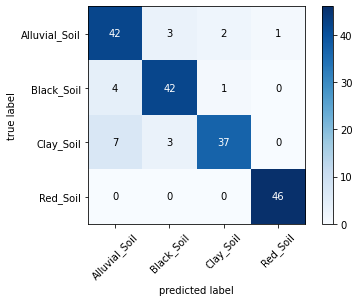

In [326]:
plot_confusion_matrix(simple_cm, colorbar=True, class_names=target_names)
plt.show()

### Accuracy & Cross Entropy Loss result plots of Train vs Test Data

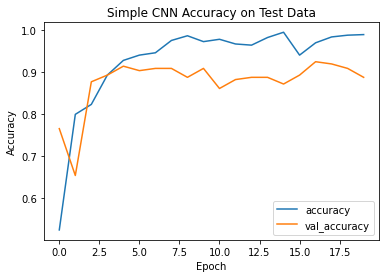

In [281]:
plt.plot(simple_history.history["accuracy"])
plt.plot(simple_history.history['val_accuracy'])
plt.title("Simple CNN Accuracy on Test Data")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["accuracy","val_accuracy"], loc='lower right')
plt.show()

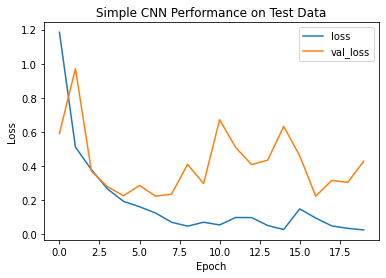

In [282]:
plt.plot(simple_history.history["loss"])
plt.plot(simple_history.history['val_loss'])
plt.title("Simple CNN Performance on Test Data")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","val_loss"], loc='upper right')
plt.show()

### Prediction Output

In [297]:
simple_predSet = simple_model.predict_generator(test_it,verbose=0)
simple_predicted_class_indices=np.argmax(simple_predSet,axis=1)
labels = (test_it.class_indices)
labels = dict((v,k) for k,v in labels.items())
simple_predictions = [labels[k] for k in simple_predicted_class_indices]
filenames=test_it.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":simple_predictions})
print(labels)
results[:50]

{0: 'Alluvial_Soil', 1: 'Black_Soil', 2: 'Clay_Soil', 3: 'Red_Soil'}


Filename    Predictions
0    Alluvial_Soil/Alluvial_1.jpg  Alluvial_Soil
1   Alluvial_Soil/Alluvial_10.jpg  Alluvial_Soil
2   Alluvial_Soil/Alluvial_11.jpg      Clay_Soil
3   Alluvial_Soil/Alluvial_12.jpg  Alluvial_Soil
4   Alluvial_Soil/Alluvial_13.jpg  Alluvial_Soil
5   Alluvial_Soil/Alluvial_14.jpg  Alluvial_Soil
6   Alluvial_Soil/Alluvial_15.jpg  Alluvial_Soil
7   Alluvial_Soil/Alluvial_16.jpg  Alluvial_Soil
8   Alluvial_Soil/Alluvial_17.jpg  Alluvial_Soil
9   Alluvial_Soil/Alluvial_18.jpg     Black_Soil
10  Alluvial_Soil/Alluvial_19.jpg  Alluvial_Soil
11   Alluvial_Soil/Alluvial_2.jpg  Alluvial_Soil
12  Alluvial_Soil/Alluvial_20.jpg  Alluvial_Soil
13  Alluvial_Soil/Alluvial_21.jpg  Alluvial_Soil
14  Alluvial_Soil/Alluvial_22.jpg  Alluvial_Soil
15  Alluvial_Soil/Alluvial_23.jpg  Alluvial_Soil
16  Alluvial_Soil/Alluvial_24.jpg  Alluvial_Soil
17  Alluvial_Soil/Alluvial_25.jpg  Alluvial_Soil
18  Alluvial_Soil/Alluvial_26.jpg     Black_Soil
19  Alluvial_Soil/Alluvial_27.jpg  Alluvial_Soil
20  Alluvial_Soil/Alluvial_28.jpg  Alluvial_Soil
21  Alluvial_Soil/Alluvial_29.jpg  Alluvial_Soil
22   Alluvial_Soil/Alluvial_3.jpg  Alluvial_Soil
23  Alluvial_Soil/Alluvial_30.jpg     Black_Soil
24  Alluvial_Soil/Alluvial_31.jpg  Alluvial_Soil
25  Alluvial_Soil/Alluvial_32.jpg  Alluvial_Soil
26  Alluvial_Soil/Alluvial_33.jpg  Alluvial_Soil
27  Alluvial_Soil/Alluvial_34.jpg  Alluvial_Soil
28  Alluvial_Soil/Alluvial_35.jpg      Clay_Soil
29  Alluvial_Soil/Alluvial_36.jpg  Alluvial_Soil
30  Alluvial_Soil/Alluvial_37.jpg  Alluvial_Soil
31  Alluvial_Soil/Alluvial_38.jpg  Alluvial_Soil
32  Alluvial_Soil/Alluvial_39.jpg  Alluvial_Soil
33   Alluvial_Soil/Alluvial_4.jpg  Alluvial_Soil
34  Alluvial_Soil/Alluvial_40.jpg  Alluvial_Soil
35  Alluvial_Soil/Alluvial_41.jpg  Alluvial_Soil
36  Alluvial_Soil/Alluvial_42.jpg  Alluvial_Soil
37  Alluvial_Soil/Alluvial_43.jpg  Alluvial_Soil
38  Alluvial_Soil/Alluvial_44.jpg  Alluvial_Soil
39  Alluvial_Soil/Alluvial_45.jpg  Alluvial_Soil
40  Alluvial_Soil/Alluvial_46.jpg  Alluvial_Soil
41  Alluvial_Soil/Alluvial_47.jpg  Alluvial_Soil
42  Alluvial_Soil/Alluvial_48.jpg  Alluvial_Soil
43   Alluvial_Soil/Alluvial_5.jpg  Alluvial_Soil
44   Alluvial_Soil/Alluvial_6.jpg  Alluvial_Soil
45   Alluvial_Soil/Alluvial_7.jpg       Red_Soil
46   Alluvial_Soil/Alluvial_8.jpg  Alluvial_Soil
47   Alluvial_Soil/Alluvial_9.jpg  Alluvial_Soil
48         Black_Soil/Black_1.jpg     Black_Soil
49        Black_Soil/Black_10.jpg     Black_Soil

Second batch of 64 images is taken from test data created using ImageDataGenerator and validated predictions of those images with model output.

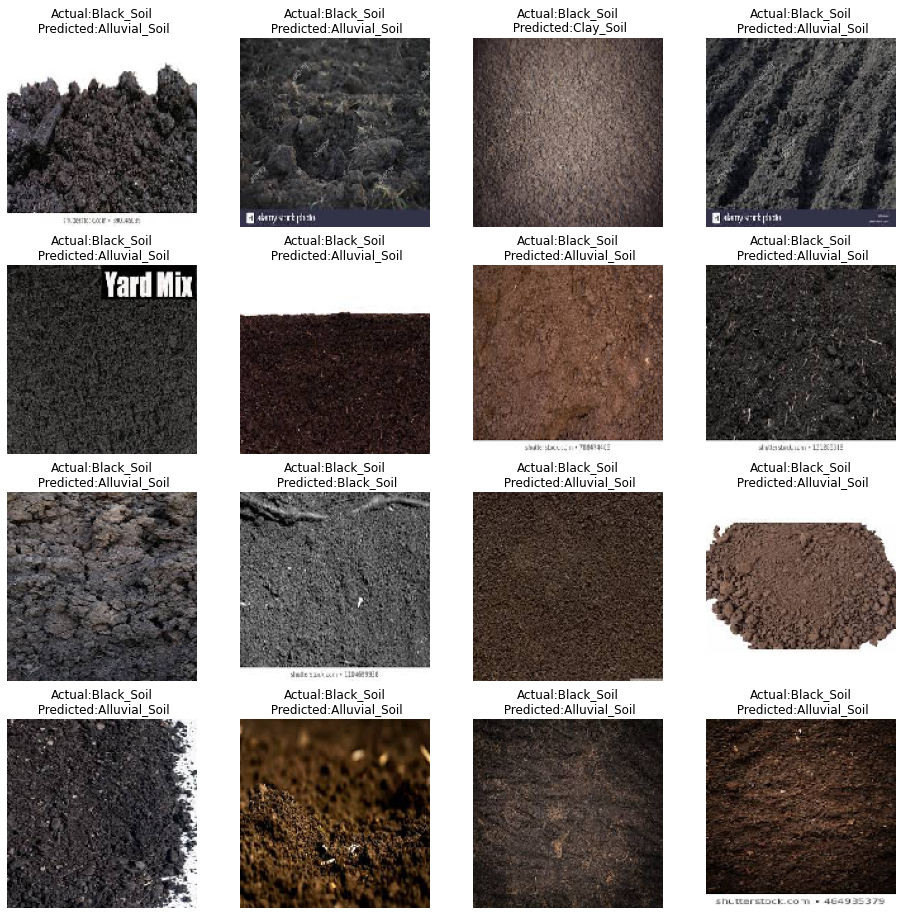

In [300]:
x,y = test_it.next()
simple_inputSet=[]
simple_actualLabelsSet=[]
simple_predictionsSet = []

for i in range(0,64):
    simple_inputSet.append(test_it[1][0][i])
    simple_actualLabelsSet.append(test_it[1][1][i])
    simple_predictionsSet.append(vgg_predictions[64+i])

plt.figure(figsize=(16,16))
for n in range(16):
    ax = plt.subplot(4,4,n+1)
    plt.imshow(simple_inputSet[n])
    plt.title("Actual:"+labels[simple_actualLabelsSet[n].argmax()]+"\n Predicted:"+str(simple_predictions[n]))
    plt.axis('off')


***
## Complex CNN with 8 layers

Implementing CNN of 8 layers with inputs:

* Creating 8 layers with input and activation function.
* ReLu is added to each layer so that any negative values will not be passed to next layer.
* Padding is added on the edges so that important features information will not be missed.
* Batch Normalization is applied after every Conv2D layers to normalize the input passing to next layer.
* Average Pooling is done after every convolutional layer to reduce the dimension of feature maps.
* Dropout is added for regularization and reduce overfitting of model.
* On top of CNN, creating flatten layer to prepare the vectors for fully connected layers.
* Then, Dense layers are added. 
* Last layer is 4 units dense with softmax activation because, there are 4 classes to predict from in the end.

In [114]:
model = Sequential()
model.add(Conv2D(64,(3,3),activation = "relu",padding ="same",kernel_initializer="he_normal", input_shape=(150,150,3)))
model.add(Conv2D(64,(3,3),activation = "relu",padding ="same",kernel_initializer="he_normal"))
model.add(BatchNormalization())


model.add(AveragePooling2D(pool_size = (2,2), strides=2))
model.add(Dropout(0.5))
model.add(BatchNormalization())


model.add(Conv2D(128,(3,3),activation = "relu",padding ="same",kernel_initializer="he_normal"))
model.add(Conv2D(128,(3,3),activation = "relu",padding ="same",kernel_initializer="he_normal"))
model.add(BatchNormalization())

model.add(AveragePooling2D(pool_size = (2,2), strides=2))
model.add(Dropout(0.5))
model.add(BatchNormalization())


model.add(Conv2D(256,(3,3),activation = "relu", padding ="same",kernel_initializer="he_normal"))
model.add(Conv2D(256,(3,3),activation = "relu",padding ="same",kernel_initializer="he_normal"))
model.add(BatchNormalization())

model.add(AveragePooling2D(pool_size = (2,2), strides=2))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.7))
model.add(Dense(4,activation="softmax"))


### Summary of model

Trainable Parameters: 43,617,092

In [115]:
model.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 150, 150, 64)      1792      
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 150, 150, 64)      36928     
_________________________________________________________________
batch_normalization_12 (Batc (None, 150, 150, 64)      256       
_________________________________________________________________
average_pooling2d_6 (Average (None, 75, 75, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 75, 75, 128)     

Model is compiled and fit

In [117]:
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])


In [118]:
start = time.time()

history = model.fit_generator(train_it, epochs=20, validation_data = test_it)
end = time.time()
print("Total train time: ",(end-start)/60," mins")

Epoch 1/20
12/12 [==============================] - 176s 15s/step - loss: 4.4737 - accuracy: 0.7497 - val_loss: 29.5991 - val_accuracy: 0.4681
Epoch 2/20
12/12 [==============================] - 158s 13s/step - loss: 3.7299 - accuracy: 0.8308 - val_loss: 69.1792 - val_accuracy: 0.4840
Epoch 3/20
12/12 [==============================] - 145s 12s/step - loss: 3.0632 - accuracy: 0.8783 - val_loss: 21.2583 - val_accuracy: 0.5745
Epoch 4/20
12/12 [==============================] - 144s 12s/step - loss: 2.8759 - accuracy: 0.8699 - val_loss: 27.9526 - val_accuracy: 0.5957
Epoch 5/20
12/12 [==============================] - 146s 12s/step - loss: 2.7584 - accuracy: 0.8503 - val_loss: 43.8700 - val_accuracy: 0.4149
Epoch 6/20
12/12 [==============================] - 147s 12s/step - loss: 1.5001 - accuracy: 0.8713 - val_loss: 48.2972 - val_accuracy: 0.4043
Epoch 7/20
12/12 [==============================] - 155s 13s/step - loss: 1.0400 - accuracy: 0.9245 - val_loss: 14.5683 - val_accuracy: 0.5851

### Performance 

Performance of the model is evaluated on the basis of Accuracy and Cross Entropy results on test dataset.\
Performance output is shown using confusion matrix.\
Also, comparison of Accuracy and Cross Entropy results shown between train and test data using graph plots.

Accuracy on test data ~ 74%

In [119]:
score = model.evaluate_generator(test_it)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.4215548038482666
Test accuracy: 0.7393617033958435


### Confusion Matrix & Classification report

Precision, Recall, f1-score results.

In [334]:
#Confution Matrix and Classification Report
num_of_test_samples = 188 
Y_pred = model.predict_generator(test_it, num_of_test_samples) 
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_it.classes, y_pred)
print('Confusion Matrix')
print(cm)
print('Classification Report')
target_names = ['Alluvial_Soil', 'Black_Soil', 'Clay_Soil', 'Red_Soil']
print(classification_report(test_it.classes, y_pred, target_names=target_names))

Confusion Matrix
[[47  1  0  0]
 [ 6 41  0  0]
 [42  0  5  0]
 [ 0  0  0 46]]
Classification Report
               precision    recall  f1-score   support

Alluvial_Soil       0.49      0.98      0.66        48
   Black_Soil       0.98      0.87      0.92        47
    Clay_Soil       1.00      0.11      0.19        47
     Red_Soil       1.00      1.00      1.00        46

     accuracy                           0.74       188
    macro avg       0.87      0.74      0.69       188
 weighted avg       0.87      0.74      0.69       188



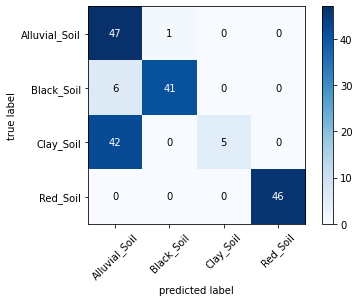

In [335]:
plot_confusion_matrix(cm, colorbar=True, class_names=target_names)
plt.show()

### Accuracy & Cross Entropy result plots of Train vs Test Data

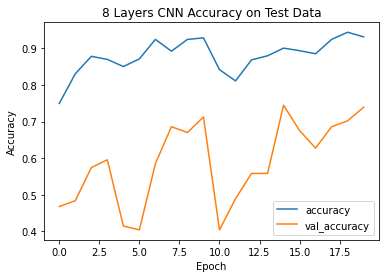

In [338]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title("8 Layers CNN Accuracy on Test Data")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["accuracy","val_accuracy"], loc='lower right')
plt.show()

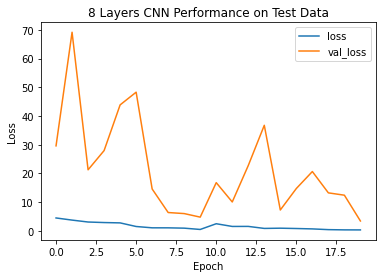

In [337]:
plt.plot(history.history["loss"])
plt.plot(history.history['val_loss'])
plt.title("8 Layers CNN Performance on Test Data")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","val_loss"], loc='upper right')
plt.show()


### Prediction Output

In [305]:
predSet = model.predict_generator(test_it,verbose=0)
predicted_class_indices=np.argmax(predSet,axis=1)
labels = (test_it.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_it.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
print(labels)
results[0:50]

{0: 'Alluvial_Soil', 1: 'Black_Soil', 2: 'Clay_Soil', 3: 'Red_Soil'}


Filename    Predictions
0    Alluvial_Soil/Alluvial_1.jpg  Alluvial_Soil
1   Alluvial_Soil/Alluvial_10.jpg  Alluvial_Soil
2   Alluvial_Soil/Alluvial_11.jpg  Alluvial_Soil
3   Alluvial_Soil/Alluvial_12.jpg  Alluvial_Soil
4   Alluvial_Soil/Alluvial_13.jpg  Alluvial_Soil
5   Alluvial_Soil/Alluvial_14.jpg  Alluvial_Soil
6   Alluvial_Soil/Alluvial_15.jpg  Alluvial_Soil
7   Alluvial_Soil/Alluvial_16.jpg  Alluvial_Soil
8   Alluvial_Soil/Alluvial_17.jpg  Alluvial_Soil
9   Alluvial_Soil/Alluvial_18.jpg  Alluvial_Soil
10  Alluvial_Soil/Alluvial_19.jpg  Alluvial_Soil
11   Alluvial_Soil/Alluvial_2.jpg  Alluvial_Soil
12  Alluvial_Soil/Alluvial_20.jpg  Alluvial_Soil
13  Alluvial_Soil/Alluvial_21.jpg  Alluvial_Soil
14  Alluvial_Soil/Alluvial_22.jpg  Alluvial_Soil
15  Alluvial_Soil/Alluvial_23.jpg  Alluvial_Soil
16  Alluvial_Soil/Alluvial_24.jpg  Alluvial_Soil
17  Alluvial_Soil/Alluvial_25.jpg  Alluvial_Soil
18  Alluvial_Soil/Alluvial_26.jpg  Alluvial_Soil
19  Alluvial_Soil/Alluvial_27.jpg  Alluvial_Soil
20  Alluvial_Soil/Alluvial_28.jpg  Alluvial_Soil
21  Alluvial_Soil/Alluvial_29.jpg  Alluvial_Soil
22   Alluvial_Soil/Alluvial_3.jpg  Alluvial_Soil
23  Alluvial_Soil/Alluvial_30.jpg     Black_Soil
24  Alluvial_Soil/Alluvial_31.jpg  Alluvial_Soil
25  Alluvial_Soil/Alluvial_32.jpg  Alluvial_Soil
26  Alluvial_Soil/Alluvial_33.jpg  Alluvial_Soil
27  Alluvial_Soil/Alluvial_34.jpg  Alluvial_Soil
28  Alluvial_Soil/Alluvial_35.jpg  Alluvial_Soil
29  Alluvial_Soil/Alluvial_36.jpg  Alluvial_Soil
30  Alluvial_Soil/Alluvial_37.jpg  Alluvial_Soil
31  Alluvial_Soil/Alluvial_38.jpg  Alluvial_Soil
32  Alluvial_Soil/Alluvial_39.jpg  Alluvial_Soil
33   Alluvial_Soil/Alluvial_4.jpg  Alluvial_Soil
34  Alluvial_Soil/Alluvial_40.jpg  Alluvial_Soil
35  Alluvial_Soil/Alluvial_41.jpg  Alluvial_Soil
36  Alluvial_Soil/Alluvial_42.jpg  Alluvial_Soil
37  Alluvial_Soil/Alluvial_43.jpg  Alluvial_Soil
38  Alluvial_Soil/Alluvial_44.jpg  Alluvial_Soil
39  Alluvial_Soil/Alluvial_45.jpg  Alluvial_Soil
40  Alluvial_Soil/Alluvial_46.jpg  Alluvial_Soil
41  Alluvial_Soil/Alluvial_47.jpg  Alluvial_Soil
42  Alluvial_Soil/Alluvial_48.jpg  Alluvial_Soil
43   Alluvial_Soil/Alluvial_5.jpg  Alluvial_Soil
44   Alluvial_Soil/Alluvial_6.jpg  Alluvial_Soil
45   Alluvial_Soil/Alluvial_7.jpg  Alluvial_Soil
46   Alluvial_Soil/Alluvial_8.jpg  Alluvial_Soil
47   Alluvial_Soil/Alluvial_9.jpg  Alluvial_Soil
48         Black_Soil/Black_1.jpg     Black_Soil
49        Black_Soil/Black_10.jpg     Black_Soil

First batch of 64 images is taken from test data created using ImageDataGenerator and validated predictions of those images with model output.

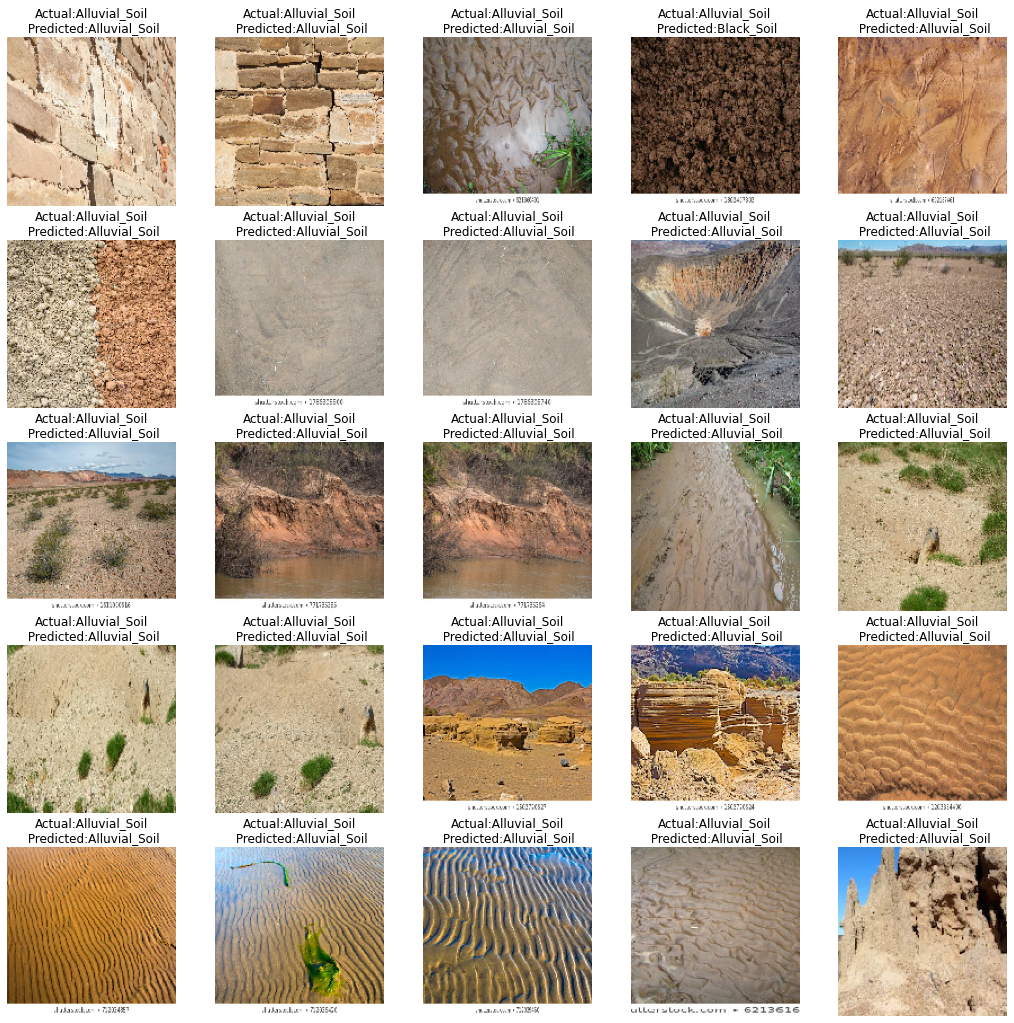

In [319]:
x,y = test_it.next()
inputSet=[]
actualLabelsSet=[]
predictionsSet = []

for i in range(0,64):
    inputSet.append(test_it[0][0][i])
    actualLabelsSet.append(test_it[0][1][i])
    predictionsSet.append(predictions[i])

plt.figure(figsize=(18,18))
for n in range(20,45):
    ax = plt.subplot(5,5,n-20+1)
    plt.imshow(inputSet[n])
    plt.title("Actual:"+labels[actualLabelsSet[n].argmax()]+"\n Predicted:"+str(predictionsSet[n]))
    plt.axis('off')


***
### VGG16 

VGG16 is CNN architecture build in 2014. Instead of using large number of hyper parameters, VGG16 uses convolutional layer with 3x3 filter with stride 1 and uses max pool layer of 2x2 filter with strides 2.

Implementing VGG16 CNN:

* Creating 16 layers with weights and activation function.
* ReLu is added to each layer so that any negative values will not be passed to next layer.
* Padding is added on the edges so that important features information will not be missed.
* Max Pooling is done after every convolutional layer with 2x2 pool size of 2 strides to reduce the dimension of feature maps.
* On top of CNN, creating flatten layer to prepare the vectors for fully connected layers.
* Then, Dense layers are added. 
* Last layer is 4 units dense with softmax activation because, there are 4 classes to predict from in the end.

In [151]:
vgg_model = Sequential()
vgg_model.add(Conv2D(input_shape=(150,150,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

vgg_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

vgg_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

vgg_model.add(Flatten())
vgg_model.add(Dense(units=4096,activation="relu"))
vgg_model.add(Dense(units=4096,activation="relu"))
vgg_model.add(Dense(units=4, activation="softmax"))

### Summary of model

Trainable Parameters: 65,070,916

In [153]:
vgg_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_83 (Conv2D)           (None, 150, 150, 64)      1792      
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 75, 75, 128)       147584    
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 37, 37, 256)     

Model is compiled and fit

In [152]:
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

start = time.time()

vgg_history = vgg_model.fit_generator(generator=train_it, validation_data= test_it, epochs=20, callbacks=[early])

end = time.time()

print("Total train time: ",(end-start)/60," mins")

### Performance 

Performance of the model is evaluated on the basis of Accuracy and Cross Entropy results on test dataset.\
Performance output is shown using confusion matrix.\
Also, comparison of Accuracy and Cross Entropy results shown between train and test data using graph plots.

Accuracy on test data ~ 25%

In [341]:
score = vgg_model.evaluate_generator(test_it)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.395052194595337
Test accuracy: 0.25


### Confusion Matrix & Classification report

Precision, Recall, f1-score results.

In [339]:
#Confusion Matrix and Classification Report
num_of_test_samples = 188 
Y_pred = vgg_model.predict_generator(test_it, num_of_test_samples) 
vgg_cm = confusion_matrix(test_it.classes, y_pred)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(vgg_cm)
print('Classification Report')
target_names = ['Alluvial_Soil', 'Black_Soil', 'Clay_Soil', 'Red_Soil']
print(classification_report(test_it.classes, y_pred, target_names=target_names))

Confusion Matrix
[[47  1  0  0]
 [ 6 41  0  0]
 [42  0  5  0]
 [ 0  0  0 46]]
Classification Report
               precision    recall  f1-score   support

Alluvial_Soil       0.00      0.00      0.00        48
   Black_Soil       0.25      1.00      0.40        47
    Clay_Soil       0.00      0.00      0.00        47
     Red_Soil       0.00      0.00      0.00        46

     accuracy                           0.25       188
    macro avg       0.06      0.25      0.10       188
 weighted avg       0.06      0.25      0.10       188



/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


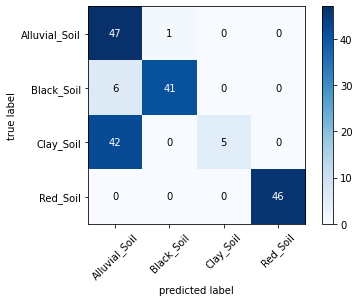

In [340]:
plot_confusion_matrix(vgg_cm, colorbar=True, class_names=target_names)
plt.show()

### Accuracy & Cross Entropy result plots of Train vs Test Data

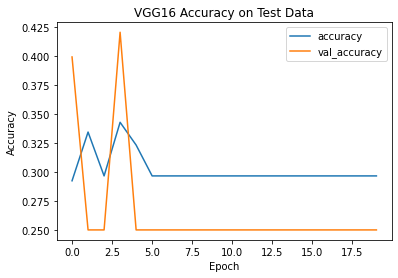

In [270]:
plt.plot(vgg_history.history["accuracy"])
plt.plot(vgg_history.history['val_accuracy'])
plt.title("VGG16 Accuracy on Test Data")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["accuracy","val_accuracy"])
plt.show()


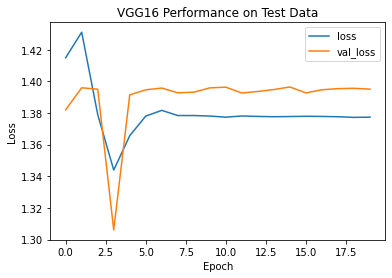

In [269]:
plt.plot(vgg_history.history["loss"])
plt.plot(vgg_history.history['val_loss'])
plt.title("VGG16 Performance on Test Data")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","val_loss"])
plt.show()

### Prediction Output

In [253]:
vgg_predSet = vgg_model.predict_generator(test_it,verbose=0)
vgg_predicted_class_indices=np.argmax(vgg_predSet,axis=1)
labels = (test_it.class_indices)
labels = dict((v,k) for k,v in labels.items())
vgg_predictions = [labels[k] for k in vgg_predicted_class_indices]
filenames=test_it.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":vgg_predictions})
results[0:50]

Filename Predictions
0    Alluvial_Soil/Alluvial_1.jpg  Black_Soil
1   Alluvial_Soil/Alluvial_10.jpg  Black_Soil
2   Alluvial_Soil/Alluvial_11.jpg  Black_Soil
3   Alluvial_Soil/Alluvial_12.jpg  Black_Soil
4   Alluvial_Soil/Alluvial_13.jpg  Black_Soil
5   Alluvial_Soil/Alluvial_14.jpg  Black_Soil
6   Alluvial_Soil/Alluvial_15.jpg  Black_Soil
7   Alluvial_Soil/Alluvial_16.jpg  Black_Soil
8   Alluvial_Soil/Alluvial_17.jpg  Black_Soil
9   Alluvial_Soil/Alluvial_18.jpg  Black_Soil
10  Alluvial_Soil/Alluvial_19.jpg  Black_Soil
11   Alluvial_Soil/Alluvial_2.jpg  Black_Soil
12  Alluvial_Soil/Alluvial_20.jpg  Black_Soil
13  Alluvial_Soil/Alluvial_21.jpg  Black_Soil
14  Alluvial_Soil/Alluvial_22.jpg  Black_Soil
15  Alluvial_Soil/Alluvial_23.jpg  Black_Soil
16  Alluvial_Soil/Alluvial_24.jpg  Black_Soil
17  Alluvial_Soil/Alluvial_25.jpg  Black_Soil
18  Alluvial_Soil/Alluvial_26.jpg  Black_Soil
19  Alluvial_Soil/Alluvial_27.jpg  Black_Soil
20  Alluvial_Soil/Alluvial_28.jpg  Black_Soil
21  Alluvial_Soil/Alluvial_29.jpg  Black_Soil
22   Alluvial_Soil/Alluvial_3.jpg  Black_Soil
23  Alluvial_Soil/Alluvial_30.jpg  Black_Soil
24  Alluvial_Soil/Alluvial_31.jpg  Black_Soil
25  Alluvial_Soil/Alluvial_32.jpg  Black_Soil
26  Alluvial_Soil/Alluvial_33.jpg  Black_Soil
27  Alluvial_Soil/Alluvial_34.jpg  Black_Soil
28  Alluvial_Soil/Alluvial_35.jpg  Black_Soil
29  Alluvial_Soil/Alluvial_36.jpg  Black_Soil
30  Alluvial_Soil/Alluvial_37.jpg  Black_Soil
31  Alluvial_Soil/Alluvial_38.jpg  Black_Soil
32  Alluvial_Soil/Alluvial_39.jpg  Black_Soil
33   Alluvial_Soil/Alluvial_4.jpg  Black_Soil
34  Alluvial_Soil/Alluvial_40.jpg  Black_Soil
35  Alluvial_Soil/Alluvial_41.jpg  Black_Soil
36  Alluvial_Soil/Alluvial_42.jpg  Black_Soil
37  Alluvial_Soil/Alluvial_43.jpg  Black_Soil
38  Alluvial_Soil/Alluvial_44.jpg  Black_Soil
39  Alluvial_Soil/Alluvial_45.jpg  Black_Soil
40  Alluvial_Soil/Alluvial_46.jpg  Black_Soil
41  Alluvial_Soil/Alluvial_47.jpg  Black_Soil
42  Alluvial_Soil/Alluvial_48.jpg  Black_Soil
43   Alluvial_Soil/Alluvial_5.jpg  Black_Soil
44   Alluvial_Soil/Alluvial_6.jpg  Black_Soil
45   Alluvial_Soil/Alluvial_7.jpg  Black_Soil
46   Alluvial_Soil/Alluvial_8.jpg  Black_Soil
47   Alluvial_Soil/Alluvial_9.jpg  Black_Soil
48         Black_Soil/Black_1.jpg  Black_Soil
49        Black_Soil/Black_10.jpg  Black_Soil

First batch of 64 images is taken from test data created using ImageDataGenerator and validated predictions of those images with model output.

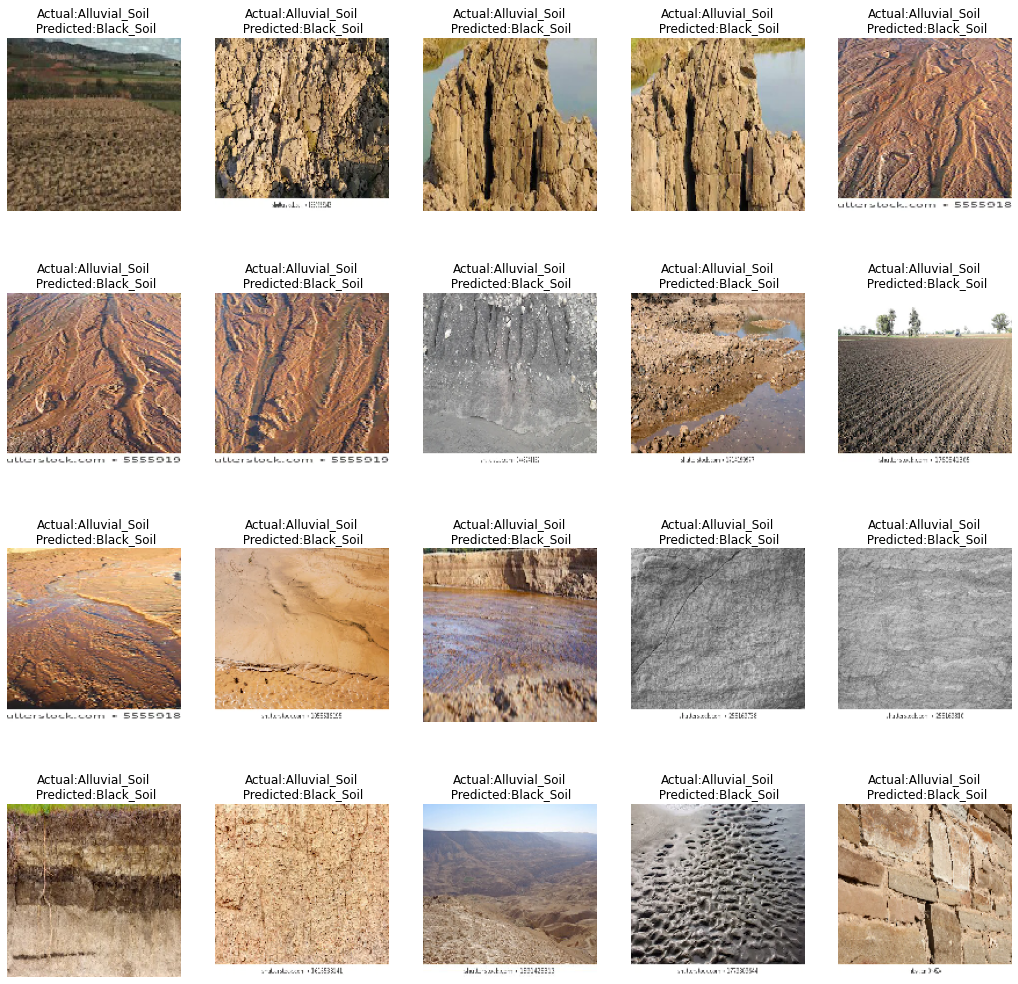

In [295]:
# x,y = test_it.next()
vgg_inputSet=[]
vgg_actualLabelsSet=[]
vgg_predictionsSet = []

for i in range(0,64):
    vgg_inputSet.append(test_it[0][0][i])
    vgg_actualLabelsSet.append(test_it[0][1][i])
    vgg_predictionsSet.append(vgg_predictions[i])

plt.figure(figsize=(18,18))
for n in range(0,20):
    ax = plt.subplot(4,5,n+1)
    plt.imshow(vgg_inputSet[n])
    plt.title("Actual:"+labels[vgg_actualLabelsSet[n].argmax()]+"\n Predicted:"+str(vgg_predictions[n]))
    plt.axis('off')

***

## Models Comparison

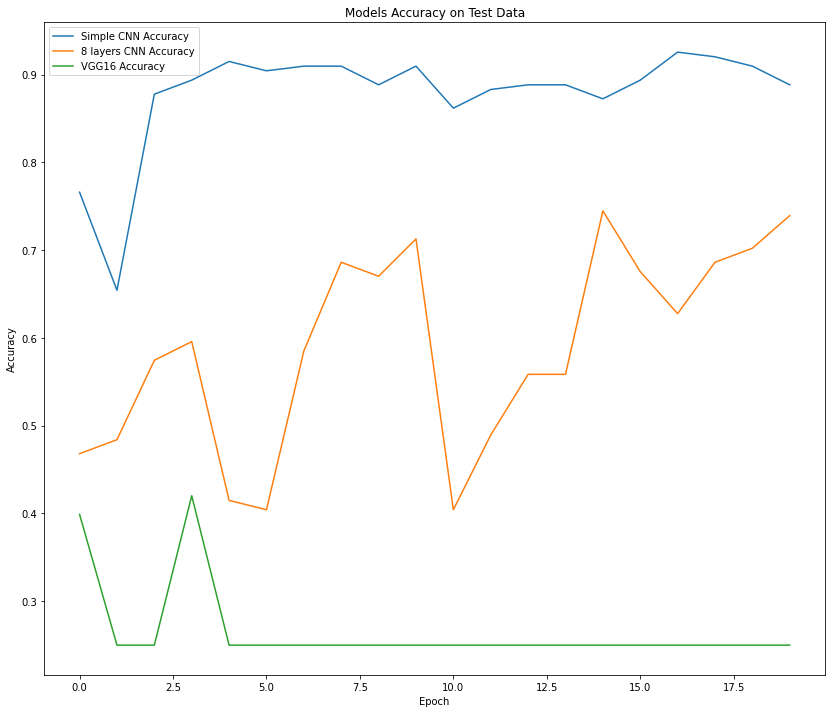

In [342]:
plt.figure(figsize=(14,12))
plt.plot(simple_history.history['val_accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title("Models Accuracy on Test Data")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Simple CNN Accuracy ","8 layers CNN Accuracy", "VGG16 Accuracy"], loc='upper left')
plt.show()

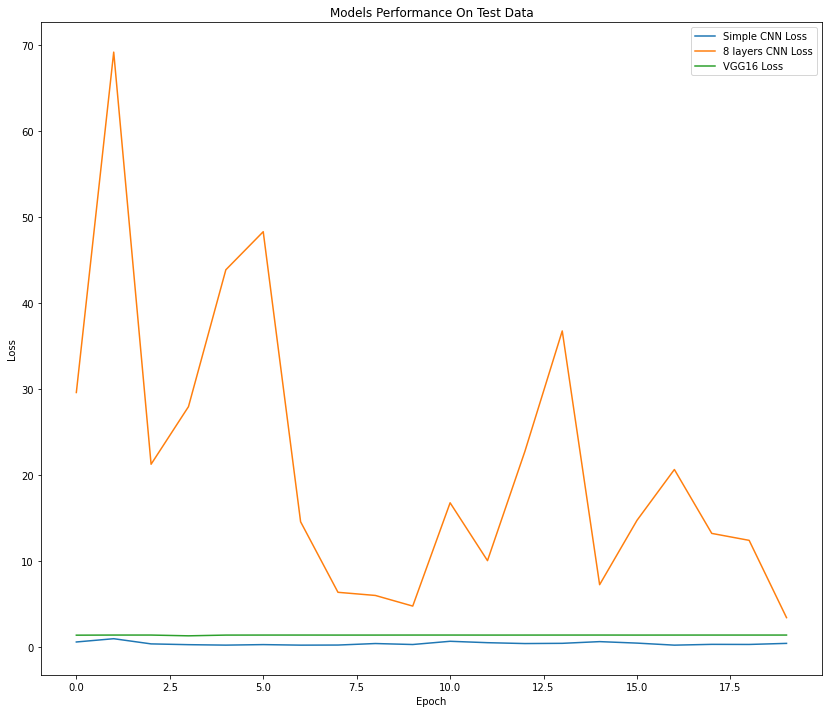

In [343]:
plt.figure(figsize=(14,12))
plt.plot(simple_history.history['val_loss'])
plt.plot(history.history['val_loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title("Models Performance On Test Data")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Simple CNN Loss ","8 layers CNN Loss", "VGG16 Loss"], loc='upper right')
plt.show()

***
## Conclusion

<p>
    
    From the above experiments it can be concluded, training complex models on simple dataset doesn't result in better performance.
    As observed from above, if we compare accuracies, simple CNN results in better accuracy of approximately 86% as compared to complex CNN and VGG16 CNN models. Also, if we have a look at VGG16, it performs much worse. In VGG16, accuracy becomes stagnant after 3 epochs only. 
    Also if we observe cross entropy, simple CNN performs better with lowest cross entropy compared to complex CNN and VGG16 CNN architecture. As seen in above cross entropy plot, complex CNN is behaving much arbitrary and fluctuating in every epoch which is not adequate for better results.
    
</p>

***
## References

* https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/  
  
  
* https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/
  
  
* https://www.tensorflow.org/tutorials/images/cnn
  
  
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
  
  
* https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/
  
  
* https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c
  
  
* https://keras.io/api/applications/vgg/